In [1]:
import numpy as np
import numpy.random as npr
from scipy import linalg as la
import matplotlib.pyplot as plt
import math as m
import pandas as pd

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


Covariance matrix: 
[[ 1.06101944  0.89340007  3.01543894]
 [ 0.89340007  9.53854268 11.32534281]
 [ 3.01543894 11.32534281 17.3562207 ]]

Eigenvalues: 
 [25.79+0.j -0.  +0.j  2.17+0.j]
Eigenvectors: 
 [[-0.12  -0.816  0.565]
 [-0.572 -0.408 -0.711]
 [-0.811  0.408  0.418]]

Eigenvalues with SVD: 
 [25.85  0.    2.17]
Eigenvectors with SVD: 
 [[-0.12  -0.816  0.565]
 [-0.572 -0.408 -0.712]
 [-0.812  0.408  0.418]]

Verify that the eigenvectors coincide (with an accurancy of 0.01): True
Verify that the eigenvalues coincide (with an accurancy of 0.1): True

For eigenvalue 1 the percent of the total dataset's variability is: 92.240870552052385 %
For eigenvalue 2 the percent of the total dataset's variability is: 0.000000000000004 %
For eigenvalue 3 the percent of the total dataset's variability is: 7.759129447947618 %

Only two pricipal components (the first and the third) contain more then 99% of the total variability, in fact when the dataset was constructed x3 was a combination of x1 a

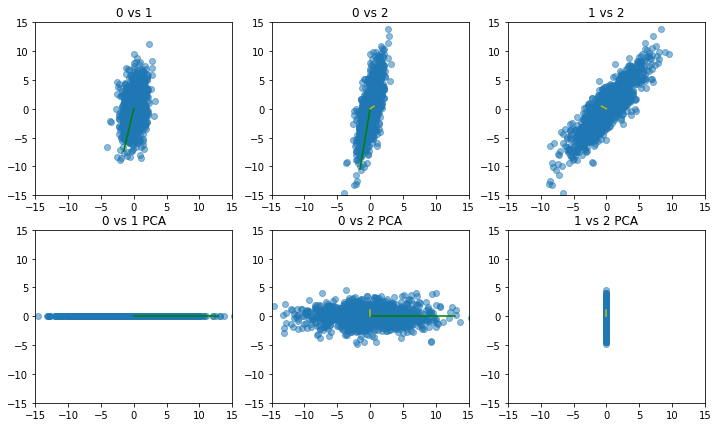

In [2]:
npr.seed(2053854)

#1
x1=npr.normal(loc=0, scale=1, size=1000)
x2=x1+npr.normal(loc=0, scale=3, size=1000)
x3=2*x1+x2

M=np.array([x1,x2,x3])

#2
covM=np.cov(M)
print("Covariance matrix: \n{}\n".format(covM))
l, V = la.eig(covM)
print("Eigenvalues: \n {}".format(l.round(2)))
print("Eigenvectors: \n {}\n".format(V.round(3))) 

#3
U, spectrum, Vt = la.svd(M)
U[:,[1,2]]=U[:,[2,1]]
spectrum[[1,2]]=spectrum[[2,1]]


print("Eigenvalues with SVD: \n {}".format((spectrum**2/(len(x1-1))).round(2)))
print("Eigenvectors with SVD: \n {}\n".format(U.round(3)))

print("Verify that the eigenvectors coincide (with an accurancy of 0.01): {}".format(np.allclose(U.round(2), V.round(2))))
print("Verify that the eigenvalues coincide (with an accurancy of 0.1): {}\n".format(np.allclose((spectrum**2/len(x1-1)).round(1), (np.real_if_close(l)).round(1))))

#4
for i in range(len(l)):
    print("For eigenvalue {} the percent of the total dataset's variability is: {:.15f} %".format(i+1, 100*abs(np.real_if_close(l)[i]/sum(np.real_if_close(l)))))

print( "\nOnly two pricipal components (the first and the third) contain more then 99% of the total variability, in fact when the dataset was constructed x3 was a combination of x1 and x2 \n")
    

    
#5
Mp=np.dot(V.T, M)


#6
scale_factor=0.5

l=np.real_if_close(l)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))

ax1.scatter(M[0,:], M[1,:], alpha=0.5)
ax1.plot([0,scale_factor*l[0]*V[0,0]], [0, scale_factor*l[0]*V[1,0]], c='g')
ax1.plot([0,scale_factor*l[1]*V[0,1]], [0, scale_factor*l[1]*V[1,1]], c='r') 
ax1.set_xlim(-15,15)
ax1.set_ylim(-15,15)
ax1.set_title("0 vs 1")

ax2.scatter(M[0,:], M[2,:], alpha=0.5)
ax2.plot([0,scale_factor*l[0]*V[0,0]], [0, scale_factor*l[0]*V[2,0]], c='g')
ax2.plot([0,scale_factor*l[2]*V[0,2]], [0, scale_factor*l[2]*V[2,2]], c='y')
ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15)
ax2.set_title("0 vs 2")

ax3.scatter(M[1,:], M[2,:], alpha=0.5)
ax3.plot([0,scale_factor*l[1]*V[1,1]], [0, scale_factor*l[1]*V[2,1]], c='r')
ax3.plot([0,scale_factor*l[2]*V[1,2]], [0, scale_factor*l[2]*V[2,2]], c='y')
ax3.set_xlim(-15,15)
ax3.set_ylim(-15,15)
ax3.set_title("1 vs 2")

scale_factor=0.5

ax4.scatter(Mp[0,:], Mp[1,:], alpha=0.5)
ax4.plot([0,scale_factor*l[0]], [0, 0], c='g')
ax4.plot([0,0], [0, scale_factor*l[1]], c='r')
ax4.set_xlim(-15,15)
ax4.set_ylim(-15,15)
ax4.set_title("0 vs 1 PCA")

ax5.scatter(Mp[0,:], Mp[2,:], alpha=0.5)
ax5.plot([0,scale_factor*l[0]], [0, 0], c='g')
ax5.plot([0,0], [0, scale_factor*l[2]], c='y')
ax5.set_xlim(-15,15)
ax5.set_ylim(-15,15)
ax5.set_title("0 vs 2 PCA")

ax6.scatter(Mp[1,:], Mp[2,:], alpha=0.5)
ax6.plot([0,scale_factor*l[1]], [0, 0], c='r')
ax6.plot([0,0], [0, scale_factor*l[2]], c='y')
ax6.set_xlim(-15,15)
ax6.set_ylim(-15,15)
ax6.set_title("1 vs 2 PCA")

M1=M #for next exercise
Mp1=Mp
l1=l

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

For eigenvalue 1 the percent of the total dataset's variability is: 92.227379360625889 %
For eigenvalue 2 the percent of the total dataset's variability is: 7.758006664428020 %
For eigenvalue 3 the percent of the total dataset's variability is: 0.000000000000003 %
For eigenvalue 4 the percent of the total dataset's variability is: 0.001229421564380 %
For eigenvalue 5 the percent of the total dataset's variability is: 0.001239440586523 %
For eigenvalue 6 the percent of the total dataset's variability is: 0.001687936067202 %
For eigenvalue 7 the percent of the total dataset's variability is: 0.001658502236514 %
For eigenvalue 8 the percent of the total dataset's variability is: 0.001625885296765 %
For eigenvalue 9 the percent of the total dataset's variability is: 0.001337228230930 %
For eigenvalue 10 the percent of the total dataset's variability is: 0.001541498778299 %
For eigenvalue 11 the percent of the total dataset's variability is: 0.001467013044362 %
For eigenvalue 12 the percent

Text(0.5, 1.0, 'PCA with the noise')

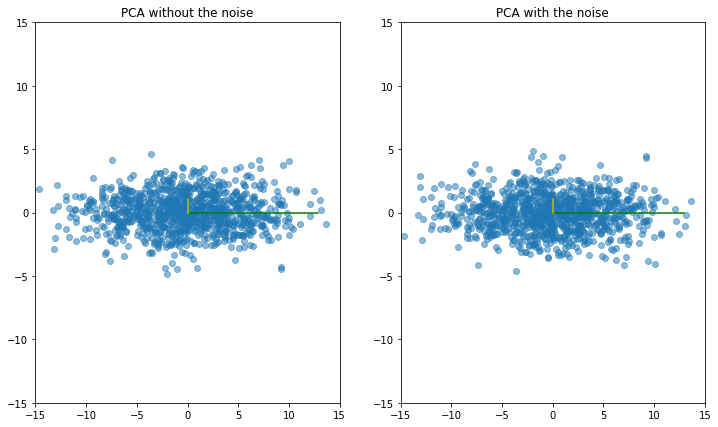

In [7]:
M=M1

for r in range(10):
    M=np.vstack([M,npr.normal(loc=0, scale=1/50, size=1000)])


covM=np.cov(M)
l, V = la.eig(covM)



for i in range(len(l)):
    print("For eigenvalue {} the percent of the total dataset's variability is: {:.15f} %".format(i+1, 100*abs(np.real_if_close(l)[i]/sum(np.real_if_close(l)))))


Mp=np.dot(V.T, M)


print("\nIt is possible to see that again the principal components are only 2 so by the PCA procedure we can reduce the problem to this 2 new cordinates and neglet the noise introduced")

scale_factor=0.5

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

ax1.scatter(Mp1[0,:], Mp1[2,:], alpha=0.5)
ax1.plot([0,scale_factor*l1[0]], [0, 0], c='g')
ax1.plot([0,0], [0, scale_factor*l1[2]], c='y')
ax1.set_xlim(-15,15)
ax1.set_ylim(-15,15)
ax1.set_title("PCA without the noise")

ax2.scatter(Mp[0,:], Mp[1,:], alpha=0.5)
ax2.plot([0,scale_factor*l[0]], [0, 0], c='g')
ax2.plot([0,0], [0, scale_factor*l[1]], c='y')
ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15)
ax2.set_title("PCA with the noise")



3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


Eigenvalues: [ 3.57000317e+00  3.11220361e-03  4.45593559e-16 -4.22579305e-16
 -3.05728852e-16 -3.05728852e-16  2.69014301e-16  2.69014301e-16
  1.58619020e-16 -1.35071297e-16  1.19308035e-16  5.71251499e-17
 -5.77468304e-17 -5.08624178e-17  2.90347753e-17  1.46555678e-17
 -4.53940042e-18 -4.53940042e-18  3.55511256e-18 -9.32817269e-19
  0.00000000e+00]
For eigenvalue 1 the percent of the total dataset's variability is: 99.912899436927020 %
For eigenvalue 2 the percent of the total dataset's variability is: 0.087100563072982 %
For eigenvalue 3 the percent of the total dataset's variability is: 0.000000000000012 %
For eigenvalue 4 the percent of the total dataset's variability is: 0.000000000000012 %
For eigenvalue 5 the percent of the total dataset's variability is: 0.000000000000009 %
For eigenvalue 6 the percent of the total dataset's variability is: 0.000000000000009 %
For eigenvalue 7 the percent of the total dataset's variability is: 0.000000000000008 %
For eigenvalue 8 the percen

Text(0.5, 0, 'time')

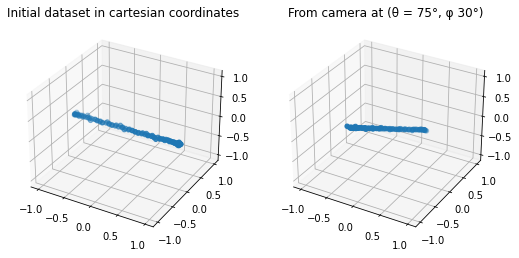

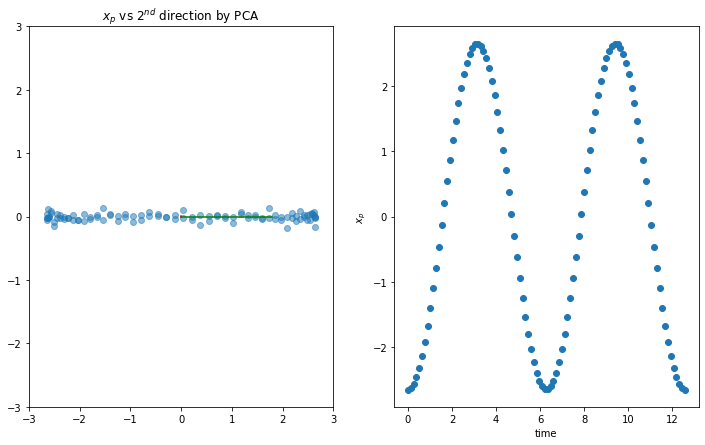

In [8]:
t=np.array(np.linspace(0,4*m.pi,100)) #time
x=np.cos(t)
y=npr.normal(loc=0, scale=1/50, size=100)
z=np.zeros(100)

Mat=np.array([x, y, z])

fig=plt.figure(figsize=plt.figaspect(0.3))

#initial plot
aax1 = fig.add_subplot(1, 3, 1, projection='3d')
aax1.scatter(Mat[0], Mat[1], Mat[2])
aax1.set_title('Initial dataset in cartesian coordinates')


def MatRot(theta, phi):
    theta=theta*m.pi/180
    phi=phi*m.pi/180
    roty=np.array([[np.cos(phi),0,np.sin(phi)],[0, 1,0], [-np.sin(phi),0,np.cos(phi)]])
    rotz=np.array([[np.cos(theta),-np.sin(theta),0], [np.sin(theta),np.cos(theta),0],[0,0,1]])
    matrot=np.dot(rotz, roty)
    return matrot

theta=[10,20,30,45,50,70,75]
phi=[0,5,38,12,84,65,30]

totMat=[]


for thet, ph in zip(theta, phi):
    Matn=np.dot(MatRot(thet, ph),Mat)
    totMat.append(Matn[0])
    totMat.append(Matn[1])
    totMat.append(Matn[2])
    
#show that rotation works   
aax2 = fig.add_subplot(1, 3, 2, projection='3d')
aax2.scatter(Matn[0], Matn[1], Matn[2]) 
aax2.set_title('From camera at (\u03B8 = {}°, \u03C6 {}°)'.format(theta[-1], phi[-1]))


for a in (aax1,aax2):
    a.set_xlim(-1.1,1.1)
    a.set_ylim(-1.1,1.1)
    a.set_zlim(-1.1,1.1)
        
        
totMat=np.array(totMat)
totl, totV = la.eig(np.cov(totMat))

totl=np.real_if_close(totl)
print("Eigenvalues: {}".format(totl))
for i in range(len(totl)):
    print("For eigenvalue {} the percent of the total dataset's variability is: {:.15f} %".format(i+1, 100*abs(totl[i]/sum(totl))))

print("\nIt is possible to see again that just one eigenvalue contains more then 99% of the total variability. The second eigenvalue rapresent the variability in the cartesian y axis")

#PCA procedure
totMatp=np.dot(totV.T, totMat)
        
print("\nSo after the PCA procedure we have reduced the problem from {} cordinates to 1 principal component.".format(len(totMat)))



#plot the dataset in the principal component

scale_factor=0.5

fig1, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

ax1.scatter(totMatp[0,:], totMatp[1,:], alpha=0.5)
ax1.plot([0,scale_factor*totl[0]], [0, 0], c='g')
ax1.plot([0,0], [0, scale_factor*totl[1]], c='r')
ax1.set_xlim(-3,3)
ax1.set_ylim(-3,3)
ax1.set_title("$x_p$ vs $2^{nd}$ direction by PCA")

ax2.scatter(t, totMatp[0,:])
ax2.set_ylabel("$x_p$")  #we have again a cosine
ax2.set_xlabel("time")


    


    


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [5]:
# get the dataset and its description on the proper data directory
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

In [6]:
file_name="~/data/magic04.data"
data=pd.read_csv(file_name, names=["fLength","fWidth","fSize","fConc","fConc1","fAsym","fM3Long","fM3Trans","fAlpha","fDist","classification"])
data=data[data['classification']=='g']  #consider only the gamma signal and not the hadron background
data=data.iloc[:,:-2].T
covm=np.cov(data)

lm, Vm = la.eig(covm)


print("Eigenvalues: {}\n".format(np.real_if_close(lm)))

for i in range(len(lm)):
    print("For eigenvalue {} the percent of the total dataset's variability is: {:.6f} %".format(i+1, 100*abs(np.real_if_close(lm)[i]/sum(np.real_if_close(lm)))))

print("\nIn this case the principal components are not just one or two as in the previous exemples but at least 5 eigenvalues contain more then 99% of the total variability, but however it could be convenient to perform the PCA procedure to reduce the dimensions of the problem")
    

#PCA 
dataPCA=np.dot(Vm.T, data)
    


Eigenvalues: [1.69871669e+03 1.48346189e+03 4.59163245e+02 2.70897199e+02
 1.83696517e+02 3.88350246e+01 4.26097666e-02 9.48788225e-03
 3.13299427e-04]

For eigenvalue 1 the percent of the total dataset's variability is: 41.083178 %
For eigenvalue 2 the percent of the total dataset's variability is: 35.877277 %
For eigenvalue 3 the percent of the total dataset's variability is: 11.104786 %
For eigenvalue 4 the percent of the total dataset's variability is: 6.551603 %
For eigenvalue 5 the percent of the total dataset's variability is: 4.442669 %
For eigenvalue 6 the percent of the total dataset's variability is: 0.939219 %
For eigenvalue 7 the percent of the total dataset's variability is: 0.001031 %
For eigenvalue 8 the percent of the total dataset's variability is: 0.000229 %
For eigenvalue 9 the percent of the total dataset's variability is: 0.000008 %

In this case the principal components are not just one or two as in the previous exemples but at least 5 eigenvalues contain more th